In [39]:
from src.paths import LOCAL_RAW_DATA_PATH, LOCAL_PROCESSED_DATA_PATH, LOCAL_MODELS_PATH


from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from tqdm._tqdm_notebook import tqdm_notebook
from collections import OrderedDict
from xgboost import plot_importance
import matplotlib.pyplot as plt 
from scipy.stats import skew
import missingno as msno
import pandas as pd
import xgboost
import pickle


tqdm_notebook.pandas()

seed = 42

df_path = LOCAL_PROCESSED_DATA_PATH / 'pretrain_dataset_20211013_ta.pkl'
df = pd.read_pickle(df_path).dropna()
tgt_vars = [c for c in df.columns if '_change_' in str(c) and not  'previous' in str(c) ]

drop_cols = ['created_at', 'created_at_trunc_h', 'id_str',
             'full_text', 'user_screen_name',
             'ma_120_periods', 'ma_720_periods'] + tgt_vars

X_cols = [c for c in df.columns if c not in drop_cols]

In [40]:
df['close_change_2periods_perc_3Q'] = pd.qcut(df['close_change_2periods_perc'], q=3)
cc1pp3Q_to_hr = {}
scale = ['DECREASE', 'NEUTRAL', 'INCREASE']
for i, v in enumerate(df['close_change_2periods_perc_3Q'].unique().sort_values()):
    cc1pp3Q_to_hr[v] = f'Q{i+1}_{scale[i]}' 
cc1pp3Q_to_hr

{Interval(-0.136, -0.00253, closed='right'): 'Q1_DECREASE',
 Interval(-0.00253, 0.0031, closed='right'): 'Q2_NEUTRAL',
 Interval(0.0031, 0.146, closed='right'): 'Q3_INCREASE'}

In [41]:
df['close_change_2periods_perc_3Q_HR'] = df['close_change_2periods_perc_3Q'].map(cc1pp3Q_to_hr)

In [42]:
# prints top 30 features (without text embeddings)
df.columns[:40]

Index([                         'created_at',
                        'created_at_trunc_h',
                                    'id_str',
                                 'full_text',
                             'retweet_count',
                            'favorite_count',
                          'user_screen_name',
                                 'user_feat',
                                       'BTC',
                                      'DOGE',
                                       'ETH',
                                       'LTC',
                                      'USDT',
                                       'ADA',
                                    'volume',
                                     'close',
                            'ma_120_periods',
                            'ma_720_periods',
                'close_change_1periods_perc',
                'close_change_2periods_perc',
                'close_change_6periods_perc',
               'close_change_12per

In [43]:
# drop columns with Text Embeddings
X_cols = [c for c in X_cols if not isinstance(c, int)]
X_cols

['retweet_count',
 'favorite_count',
 'user_feat',
 'BTC',
 'DOGE',
 'ETH',
 'LTC',
 'USDT',
 'ADA',
 'volume',
 'close',
 'close_change_previous24periods_perc',
 'close_change_previous12periods_perc',
 'close_change_previous6periods_perc',
 'close_change_previous2periods_perc',
 'close_change_previous1periods_perc',
 'day_of_month',
 'up',
 'down',
 'RSI',
 'MSA',
 'EMA']

In [44]:
X = df[X_cols]
y = df['close_change_2periods_perc_3Q_HR']

In [45]:
X.isna().sum().sum(), y.isna().sum()

(0, 0)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

In [47]:
print(X_train.shape,  X_test.shape)
print(y_train.shape,  y_test.shape)
df.shape[0] == X_train.shape[0] + X_test.shape[0] 

(61888, 22) (15472, 22)
(61888,) (15472,)


True

In [48]:
# xgboost.XGBClassifier
# xgboost.XGBRFClassifier

In [49]:
xgboost.set_config(**{'use_rmm': False, 'verbosity': 1})

model = xgboost.XGBRFClassifier(**{
    'colsample_bytree': 0.8,
    'gamma': 0,
    'learning_rate': 0.01,
    'max_depth': 5,
    'min_child_weight': 1.5,
    'n_estimators': 1200,
    'reg_alpha': 0.75,
    'reg_lambda': 0.45,
    'seed': seed,
    'subsample': 0.9
}) 


%time model.fit(X_train,y_train)

c:\users\muril\.virtualenvs\crypto-prophet-ckjwbuny\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:58:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 1min 37s


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=0.8, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.01, max_delta_step=0, max_depth=5,
                min_child_weight=1.5, missing=nan, monotone_constraints='()',
                n_estimators=1200, n_jobs=8, num_parallel_tree=1200,
                objective='multi:softprob', random_state=42, reg_alpha=0.75,
                reg_lambda=0.45, scale_pos_weight=None, seed=42, subsample=0.9,
                tree_method='exact', validate_parameters=1, verbosity=None)

In [50]:
with open(LOCAL_MODELS_PATH / 'xgboost_20211014_XGBRFClassifier_3Q2H_ta_only.pkl', mode='wb') as fp:
    pickle.dump(model, fp)

In [51]:
from sklearn.metrics import accuracy_score
accuracy_score(y, model.predict(X))

0.5331954498448811

In [52]:
accuracy_score(y_test, model.predict(X_test))

0.5222337125129266

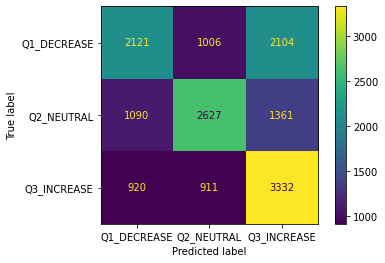

In [53]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test)  

In [54]:
user2score = []
for u in X_train.user_feat.unique():
    mask = X.user_feat == u
    user_screen_name = user_le.inverse_transform([u])[0]
    stats ={
        'user_label': u,
        'user_screen_name': user_screen_name,
        'accuracy': model.score(X[mask], y[mask]),
        'tweet_count': mask.sum()}
    user2score.append(stats)
user2score = pd.DataFrame(user2score).sort_values('accuracy', ascending=False)

In [55]:
user2score

,user_label,user_screen_name,accuracy,tweet_count
2,41,officialmcafee,0.647848,3206
25,23,TheCryptoDog,0.603291,2309
16,16,KennethBosak,0.590769,3250
26,14,FEhrsam,0.587859,313
22,34,davidgokhshtein,0.580308,3250
14,35,elonmusk,0.567397,3012
1,40,mysticaloaks,0.566154,3250
31,19,PeterMcCormack,0.565032,938
11,10,CryptoWendyO,0.561496,3236
21,15,IvanOnTech,0.558567,3210
